In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from hyperopt.pyll import scope
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) MinMaxScaler cho X & y (fit trên TRAIN) ==================
xs = MinMaxScaler()
ys = MinMaxScaler()

X_train_prepared = xs.fit_transform(X_train)
X_test_prepared  = xs.transform(X_test)

y_train_prepared = ys.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_prepared  = ys.transform(y_test.values.reshape(-1, 1)).ravel()

# ================== 4) RandomizedSearchCV (CatBoost) ==================
param_distributions = {
    "n_estimators": [100, 200, 400],
    "learning_rate": [0.01, 0.03, 0.1, 0.2],
    "max_depth": [4, 6, 8, 10]   
}

model = GradientBoostingRegressor()

ran_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,                               
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=SEED
)

ran_search.fit(X_train_prepared, y_train_prepared)

best_model   = ran_search.best_estimator_
best_params  = ran_search.best_params_
best_cv_rmse = np.sqrt(-ran_search.best_score_)   # RMSE trên THANG ĐÃ SCALE (y đã scale)

print("Best params:", best_params)
print(f"Best CV RMSE (scaled y): {best_cv_rmse:.6f}")

Best params: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.2}
Best CV RMSE (scaled y): 0.005358


In [5]:

# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
# Note: Data path may need to be adjusted based on your environment
data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = ['Original_len', 'Txn Fee', 'logIndex', 'actualGasCost',
            'Blockno', 'DateTime_ts', 'nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) CROSS-VALIDATION (CV metrics on scaled data) ==================
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

mse_scores, mae_scores, rmse_scores, r2_scores = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), start=1):
    # --- split fold ---
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # --- scale INSIDE fold (fit trên train fold) ---
    xs, ys = MinMaxScaler(), MinMaxScaler()
    X_tr_s = xs.fit_transform(X_tr)
    X_te_s = xs.transform(X_te)
    y_tr_s = ys.fit_transform(y_tr.values.reshape(-1, 1)).ravel()
    y_te_s = ys.transform(y_te.values.reshape(-1, 1)).ravel()

  
    model = GradientBoostingRegressor(n_estimators= 200, max_depth= 8, learning_rate= 0.2)
    model.fit(
        X_tr_s, y_tr_s
    )

    # --- predict & metrics ---
    y_pred_s = model.predict(X_te_s)


    mse = mean_squared_error(y_te_s, y_pred_s)
    mae = mean_absolute_error(y_te_s, y_pred_s)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_te_s, y_pred_s)

    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"[Fold {fold}] (SCALED) MSE={mse:.6f} | RMSE={rmse:.6f} | MAE={mae:.6f} | R²={r2:.6f}")

# ================== 4) CV AVERAGE ==================
print("\n=== CV AVERAGE (SCALED) ===")
print(f"Avg MSE : {np.mean(mse_scores):.6f}")
print(f"Avg MAE : {np.mean(mae_scores):.6f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.6f}")
print(f"Avg R²  : {np.mean(r2_scores):.6f}")

[Fold 1] (SCALED) MSE=0.000024 | RMSE=0.004853 | MAE=0.002613 | R²=0.848934
[Fold 2] (SCALED) MSE=0.000021 | RMSE=0.004605 | MAE=0.002637 | R²=0.842053
[Fold 3] (SCALED) MSE=0.000036 | RMSE=0.006032 | MAE=0.002648 | R²=0.777820
[Fold 4] (SCALED) MSE=0.000022 | RMSE=0.004717 | MAE=0.002602 | R²=0.847636
[Fold 5] (SCALED) MSE=0.000028 | RMSE=0.005335 | MAE=0.002607 | R²=0.816879
[Fold 6] (SCALED) MSE=0.000027 | RMSE=0.005201 | MAE=0.002634 | R²=0.813934
[Fold 7] (SCALED) MSE=0.000025 | RMSE=0.004959 | MAE=0.002629 | R²=0.841265
[Fold 8] (SCALED) MSE=0.000025 | RMSE=0.005003 | MAE=0.002622 | R²=0.834552
[Fold 9] (SCALED) MSE=0.000099 | RMSE=0.009957 | MAE=0.004059 | R²=0.774466
[Fold 10] (SCALED) MSE=0.000034 | RMSE=0.005800 | MAE=0.002645 | R²=0.787191

=== CV AVERAGE (SCALED) ===
Avg MSE : 0.000034
Avg MAE : 0.002770
Avg RMSE: 0.005646
Avg R²  : 0.818473


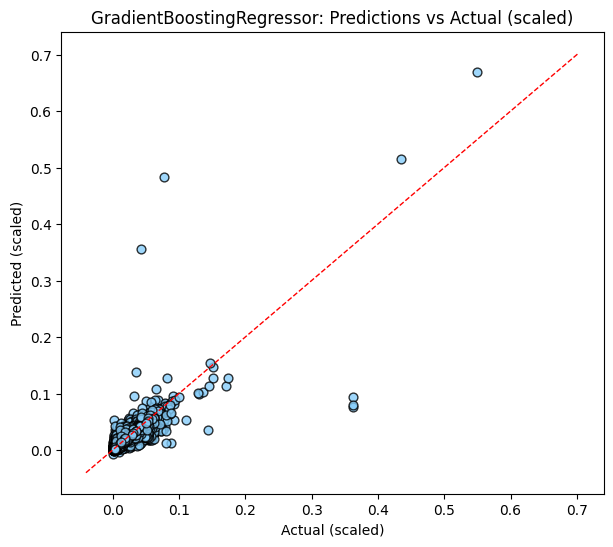

In [6]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)
# ================== 4) TRAIN CATBOOST (SCALED) ==================
cb = GradientBoostingRegressor(n_estimators= 200, max_depth= 8, learning_rate= 0.2)
cb.fit(X_tr_s, y_tr_s)

# ================== 5) PREDICT & SCATTER (SCALED) ==================
y_val_pred_s = cb.predict(X_te_s)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y_te_s, y_val_pred_s, s=40, alpha=0.8,
           color="lightskyblue", edgecolors="k")

# Đường y = x theo giới hạn hiện tại của trục (không dùng 'lims')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([min(x0, y0), max(x1, y1)], [min(x0, y0), max(x1, y1)],
        "--", lw=1, color="red")

ax.set_title("GradientBoostingRegressor: Predictions vs Actual (scaled)")
ax.set_xlabel("Actual (scaled)")
ax.set_ylabel("Predicted (scaled)")
plt.show()

In [7]:
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = [
  'Original_len',
'Txn Fee','logIndex','actualGasCost',
    'Blockno','DateTime_ts',  'nonce'
]
target = 'Gas Used'


X = df[features].astype(float)
y = df[target].astype(float)

# Hold-out chỉ để cố định tập làm việc (không dùng test ở dưới)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# ================== 2) 20 EPOCHS × 10-FOLD ==================
epochs = 20
ct = np.zeros((epochs, 4), dtype=np.float64)   # [RMSE, MSE, MAE, R2]

for ep in range(epochs):
    # shuffle train cho epoch này
    idx = np.random.permutation(len(X_train))
    X_ep = X_train.iloc[idx].reset_index(drop=True)
    y_ep = y_train.iloc[idx].reset_index(drop=True)

    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

    rmse_scores, mse_scores, mae_scores, r2_scores = [], [], [], []

    for train_idx, test_idx in kf.split(X_ep):
        X_tr_raw, X_tes_raw = X_ep.iloc[train_idx], X_ep.iloc[test_idx]
        y_tr_raw, y_tes_raw = y_ep.iloc[train_idx], y_ep.iloc[test_idx]

        # scale TRONG fold (fit trên train → transform train/val)
        xs, ys = MinMaxScaler(), MinMaxScaler()
        X_tr_s = xs.fit_transform(X_tr_raw)
        X_tes_s = xs.transform(X_tes_raw)
        y_tr_s = ys.fit_transform(y_tr_raw.values.reshape(-1,1)).ravel()
        y_tes_s = ys.transform(y_tes_raw.values.reshape(-1,1)).ravel()


        # --- CatBoost ---
        model = GradientBoostingRegressor(n_estimators= 200, max_depth= 8, learning_rate= 0.2)
        model.fit(
        X_tr_s, y_tr_s
       
    )

        # metrics trên dữ liệu ĐÃ SCALE
        y_pred_s = model.predict(X_tes_s)
        mse  = mean_squared_error(y_tes_s, y_pred_s)
        rmse = float(np.sqrt(mse))
        mae  = mean_absolute_error(y_tes_s, y_pred_s)
        r2   = r2_score(y_tes_s, y_pred_s)

        rmse_scores.append(rmse); mse_scores.append(mse)
        mae_scores.append(mae);   r2_scores.append(r2)

    ct[ep, :] = [np.mean(rmse_scores), np.mean(mse_scores),
                 np.mean(mae_scores),  np.mean(r2_scores)]

# ================== 3) OUTPUT ==================
np.set_printoptions(precision=8, suppress=False)
print("array(" + np.array2string(ct, separator=', ', prefix='array(') + ")")

final_mean = ct.mean(axis=0)
final_std  = ct.std(axis=0, ddof=1)
print("\nMean over 20 runs (RMSE, MSE, MAE, R2):", final_mean)
print("Std  over 20 runs (RMSE, MSE, MAE, R2):", final_std)

array([[5.57043611e-03, 3.31932322e-05, 2.76549074e-03, 8.22976564e-01],
       [5.62744475e-03, 3.33952387e-05, 2.77093526e-03, 8.17260571e-01],
       [5.63492312e-03, 3.41907744e-05, 2.76725575e-03, 8.18930920e-01],
       [5.63906297e-03, 3.46373391e-05, 2.76061122e-03, 8.19721353e-01],
       [5.67601345e-03, 3.47698849e-05, 2.78021368e-03, 8.18061991e-01],
       [5.70156001e-03, 3.49688728e-05, 2.77062992e-03, 8.16155685e-01],
       [5.61175922e-03, 3.33063437e-05, 2.76347967e-03, 8.19331240e-01],
       [5.62803618e-03, 3.37573998e-05, 2.76614368e-03, 8.19503471e-01],
       [5.59753266e-03, 3.34689431e-05, 2.77062765e-03, 8.20603479e-01],
       [5.75335701e-03, 3.73356399e-05, 2.76008541e-03, 8.14711048e-01],
       [5.59879968e-03, 3.38111730e-05, 2.76568090e-03, 8.21636158e-01],
       [5.59794885e-03, 3.33529650e-05, 2.76640198e-03, 8.20506768e-01],
       [5.74008943e-03, 3.51679232e-05, 2.76438444e-03, 8.12150818e-01],
       [5.65731474e-03, 3.40965531e-05, 2.76253246e

In [ ]:
#entrypoint address v07 1 time
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from hyperopt.pyll import scope
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, train_test_split
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d7/total 7.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) CROSS-VALIDATION (CV metrics on scaled data) ==================
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

mse_scores, mae_scores, rmse_scores, r2_scores = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), start=1):
    # --- split fold ---
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # --- scale INSIDE fold (fit trên train fold) ---
    xs, ys = MinMaxScaler(), MinMaxScaler()
    X_tr_s = xs.fit_transform(X_tr)
    X_te_s = xs.transform(X_te)
    y_tr_s = ys.fit_transform(y_tr.values.reshape(-1, 1)).ravel()
    y_te_s = ys.transform(y_te.values.reshape(-1, 1)).ravel()

  
    model = GradientBoostingRegressor(n_estimators= 200, max_depth= 8, learning_rate= 0.2)
    model.fit(
        X_tr_s, y_tr_s
    )

    # --- predict & metrics ---
    y_pred_s = model.predict(X_te_s)


    mse = mean_squared_error(y_te_s, y_pred_s)
    mae = mean_absolute_error(y_te_s, y_pred_s)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_te_s, y_pred_s)

    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"[Fold {fold}] (SCALED) MSE={mse:.6f} | RMSE={rmse:.6f} | MAE={mae:.6f} | R²={r2:.6f}")

# ================== 4) CV AVERAGE ==================
print("\n=== CV AVERAGE (SCALED) ===")
print(f"Avg MSE : {np.mean(mse_scores):.6f}")
print(f"Avg MAE : {np.mean(mae_scores):.6f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.6f}")
print(f"Avg R²  : {np.mean(r2_scores):.6f}")

[Fold 1] (SCALED) MSE=0.000174 | RMSE=0.013180 | MAE=0.001449 | R²=0.374254
[Fold 2] (SCALED) MSE=0.000006 | RMSE=0.002451 | MAE=0.001183 | R²=0.916048
[Fold 3] (SCALED) MSE=0.000006 | RMSE=0.002539 | MAE=0.001201 | R²=0.912879
[Fold 4] (SCALED) MSE=0.000006 | RMSE=0.002457 | MAE=0.001194 | R²=0.914248
[Fold 5] (SCALED) MSE=0.000007 | RMSE=0.002575 | MAE=0.001237 | R²=0.914086
[Fold 6] (SCALED) MSE=0.000006 | RMSE=0.002456 | MAE=0.001206 | R²=0.915963
[Fold 7] (SCALED) MSE=0.000199 | RMSE=0.014097 | MAE=0.001437 | R²=0.262930
[Fold 8] (SCALED) MSE=0.000006 | RMSE=0.002372 | MAE=0.001209 | R²=0.924492
[Fold 9] (SCALED) MSE=0.000123 | RMSE=0.011107 | MAE=0.001370 | R²=-0.673226
[Fold 10] (SCALED) MSE=0.000009 | RMSE=0.002989 | MAE=0.001197 | R²=0.879873

=== CV AVERAGE (SCALED) ===
Avg MSE : 0.000054
Avg MAE : 0.001268
Avg RMSE: 0.005622
Avg R²  : 0.634155
